### Big Market Sales Prediction

2013 sales data for 1559 products across 10 stores in different cities

#### Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import KFold



#### Load Data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/ABB/data/train_v9rqX0R.csv') #We split it to (x_train,y_train), (x_test,y_test), 80:20 Split
df_test  = pd.read_csv('/content/drive/MyDrive/ABB/data/test_AbJTz2l.csv') #We test final model on this data

In [ ]:
df_train.shape, df_test.shape

((8523, 12), (5681, 11))

#### Training Data Deep Dive

In [ ]:
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##### Data information

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#### Null Count

In [ ]:
print(df_train.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


##### Statistical Insights

In [ ]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Item_Identifier,8523,1559,FDW13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Weight,7060.0,NaN,NaN,NaN,12.857645,4.643456,4.555,8.77375,12.6,16.85,21.35
Item_Fat_Content,8523,5,Low Fat,5089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_Visibility,8523.0,NaN,NaN,NaN,0.066132,0.051598,0.0,0.026989,0.053931,0.094585,0.328391
Item_Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Item_MRP,8523.0,NaN,NaN,NaN,140.992782,62.275067,31.29,93.8265,143.0128,185.6437,266.8884
Outlet_Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Establishment_Year,8523.0,NaN,NaN,NaN,1997.831867,8.37176,1985.0,1987.0,1999.0,2004.0,2009.0
Outlet_Size,6113,3,Medium,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Outlet_Location_Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Feature: Item_Code

In [ ]:
df_train['Item_Code'] = df_train['Item_Identifier'].str[:2]
df_test['Item_Code'] = df_test['Item_Identifier'].str[:2]
print(len(df_train['Item_Code'].unique()))
df_train['Item_Code'].unique()

3


array(['FD', 'DR', 'NC'], dtype=object)

Handling Null Value in Item_Weight

In [ ]:
item_code_weight_medians = df_train.groupby('Item_Code')['Item_Weight'].median()
global_weight_median = df_train['Item_Weight'].median()

def impute_weight(row):
    if pd.isna(row['Item_Weight']):
        return item_code_weight_medians.get(row['Item_Code'], global_weight_median)
    return row['Item_Weight']

df_train['Item_Weight'] = df_train.apply(impute_weight, axis=1)
df_test['Item_Weight'] = df_test.apply(impute_weight, axis=1)

Handling Null Value in Outlet Size

In [ ]:
# 1. Safe mode function
def safe_mode(series):
    mode_vals = series.mode()
    if len(mode_vals) > 0:
        return mode_vals.iloc[0]
    else:
        return 'Medium'

# 2. Compute outlet_size_mode safely
outlet_size_mode = df_train.groupby(['Outlet_Type', 'Outlet_Location_Type'])['Outlet_Size'].agg(safe_mode)

# 3. Imputation function
def impute_outlet_size(row):
    if pd.isna(row['Outlet_Size']):
        return outlet_size_mode.get(
            (row['Outlet_Type'], row['Outlet_Location_Type']),
            'Medium'  # fallback if combination not found
        )
    return row['Outlet_Size']

# 4. Apply to both train and test
df_train['Outlet_Size'] = df_train.apply(impute_outlet_size, axis=1)
df_test['Outlet_Size'] = df_test.apply(impute_outlet_size, axis=1)


#### Exploring Categorical Columns

In [ ]:
categorical_cols = df_train.select_dtypes(include='object').columns.tolist()
print(categorical_cols)

['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Code']


##### Checking For Irregular Values in columns

In [ ]:
print(df_train['Item_Fat_Content'].unique())
print(df_train['Item_Type'].unique())
print(df_train['Outlet_Identifier'].unique())
print(df_train['Outlet_Size'].unique())
print(df_train['Outlet_Location_Type'].unique())
print(df_train['Outlet_Type'].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Medium' 'High' 'Small']
['Tier 1' 'Tier 3' 'Tier 2']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


##### Handling Inconsistent value in Item_Fat_Content

In [ ]:
#Train Data
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].replace({'reg': 'Regular', 'LF': 'Low Fat', 'low fat': 'Low Fat', })
print(df_train['Item_Fat_Content'].value_counts())

#Test Data
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].replace({'reg': 'Regular', 'LF': 'Low Fat', 'low fat': 'Low Fat', })
print(df_test['Item_Fat_Content'].value_counts())


Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64
Item_Fat_Content
Low Fat    3668
Regular    2013
Name: count, dtype: int64


Analyzing Features

Item_Outlet_Sales Distribution

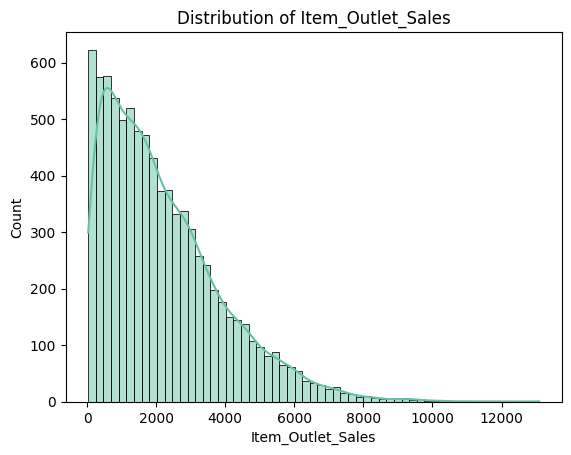

In [ ]:
sns.histplot(df_train['Item_Outlet_Sales'], kde=True)
plt.title("Distribution of Item_Outlet_Sales")
plt.show()


Applying Log on Item_Outlet_Sales

In [ ]:

df_train['Log_Sales'] = np.log1p(df_train['Item_Outlet_Sales'])

#After prediction, invertion is required -
# pred_sales = np.expm1(model.predict(X_test))



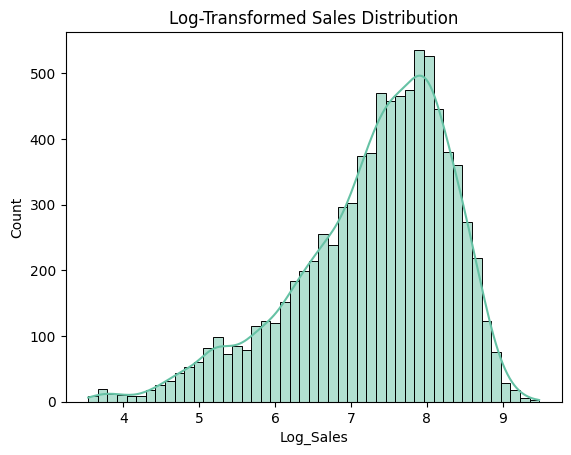

In [ ]:
sns.histplot(df_train['Log_Sales'], kde=True)
plt.title("Log-Transformed Sales Distribution")
plt.show()

Item_MRP vs Item_Outlet_Sales

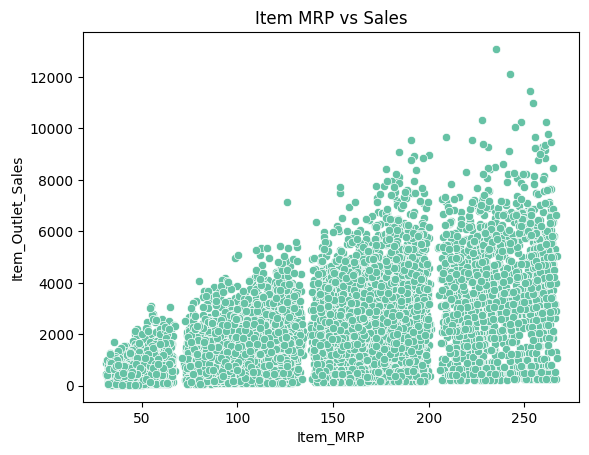

In [ ]:
# MRP vs Sales
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=df_train)
plt.title("Item MRP vs Sales")
plt.show()

Item_Visibility vs Item_Outlet_Sales

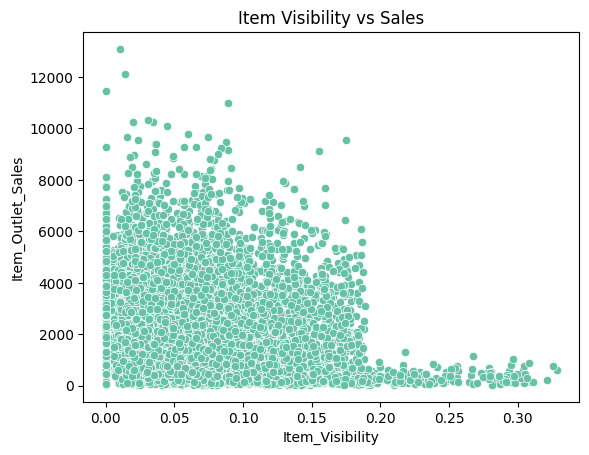

In [ ]:
# Item_Visibility vs Sales
sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=df_train)
plt.title("Item Visibility vs Sales")
plt.show()


In [ ]:
#Total Items with 0 visibility
(df_train['Item_Visibility'] == 0).sum()

np.int64(526)

In [ ]:
# Total Unique Items with 0 visibility
unique_items_zero_visibility = df_train[df_train['Item_Visibility'] == 0]['Item_Identifier'].unique()
print(len(unique_items_zero_visibility))
# print(unique_items_zero_visibility)


446


Handling 0 Item_Visibility

In [ ]:
# Compute item-level and item+outlet-level medians (ignoring 0s)
'''
We see more than 6% data points have item_visibility = 0
This appears to be an error in the data.
To handle this we try to impute item_visibility based on the data we have.
If item visibility of an item in an outlet is 0, we first try to scheck median item visibility of item,outlet combination and replace it with it.
If item, outlet combination doesnt exist, we try to impute with the median of the item's visibility.
If that too doesn't exist we impute it with global item visibility.
'''
item_medians = df_train[df_train['Item_Visibility'] > 0].groupby(
    'Item_Identifier')['Item_Visibility'].median()

item_outlet_medians = df_train[df_train['Item_Visibility'] > 0].groupby(
    ['Item_Identifier', 'Outlet_Identifier']
)['Item_Visibility'].median()

# Define fallback median
global_median = df_train[df_train['Item_Visibility'] > 0]['Item_Visibility'].median()

# Function to fill visibility
def fill_visibility(row):
    if row['Item_Visibility'] == 0:
        return item_outlet_medians.get(
            (row['Item_Identifier'], row['Outlet_Identifier']),
            item_medians.get(
                row['Item_Identifier'],
                global_median
            )
        )
    return row['Item_Visibility']

#Lets first preserve the existing visibility = 0 value
df_train['Is_Visibility_Zero'] = (df_train['Item_Visibility'] == 0).astype(int)
df_test['Is_Visibility_Zero'] = (df_test['Item_Visibility'] == 0).astype(int)

# Applying function to each row
df_train['Item_Visibility'] = df_train.apply(fill_visibility, axis=1)
df_test['Item_Visibility'] = df_test.apply(fill_visibility,axis=1)

#Applying Log Transform to handle skewness
df_train['Log_Visibility'] = np.log1p(df_train['Item_Visibility'])
df_test['Log_Visibility'] = np.log1p(df_test['Item_Visibility'])



Item_Weight vs Item_Outlet_Sales

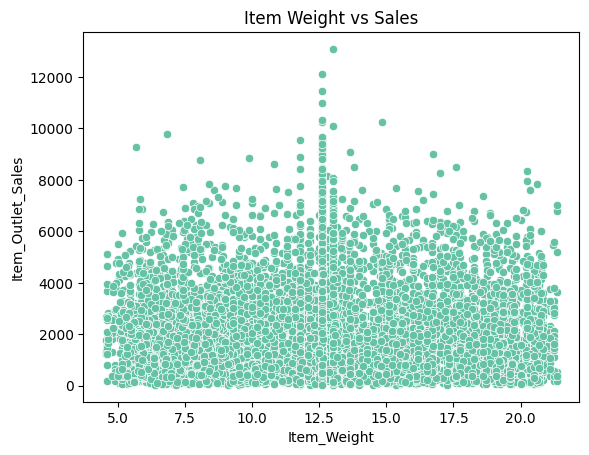

In [ ]:
# MRP vs Sales
sns.scatterplot(x='Item_Weight', y='Item_Outlet_Sales', data=df_train)
plt.title("Item Weight vs Sales")
plt.show()

Categorical Feature Analysis

Item_Type vs Item_Outlet_Sales

/tmp/ipython-input-546-501119266.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Item_Type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


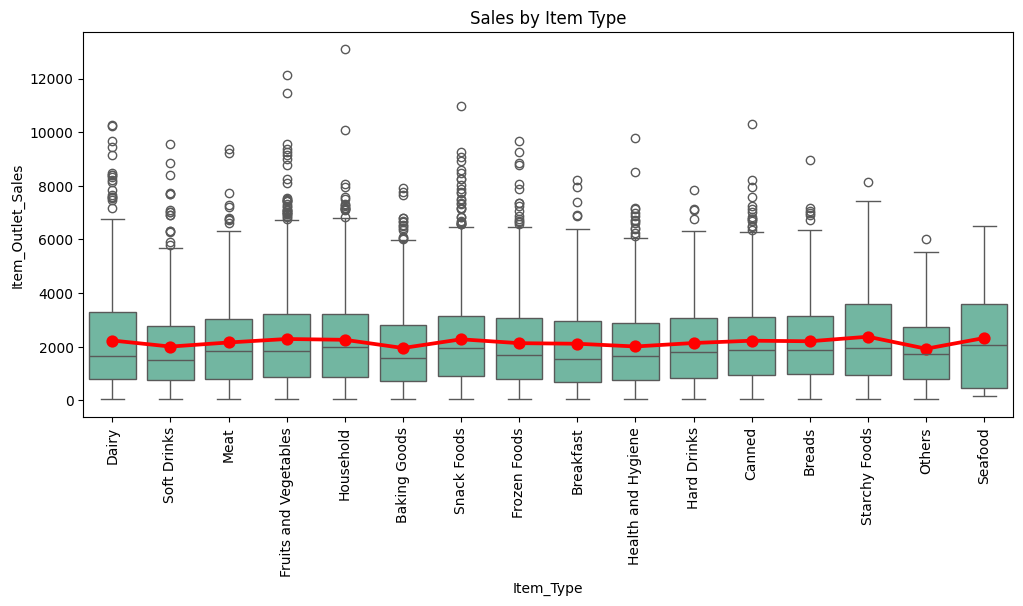

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='Item_Type', y='Item_Outlet_Sales', data=df_train)
sns.pointplot(x='Item_Type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.xticks(rotation=90)
plt.title("Sales by Item Type")
plt.show()


Outlet Type vs Item_Outlet_Sales

/tmp/ipython-input-547-2179781870.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


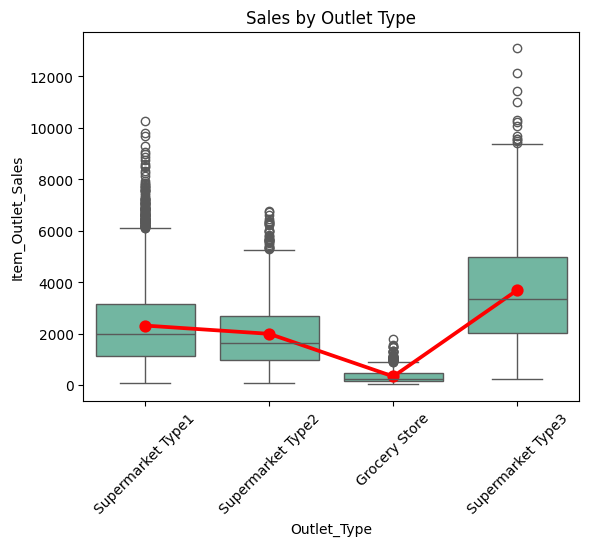

In [ ]:
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by Outlet Type")
sns.pointplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.xticks(rotation=45)
plt.show()


Outlet_Location_Type vs Item_Outlet_Sales

/tmp/ipython-input-548-2773047284.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


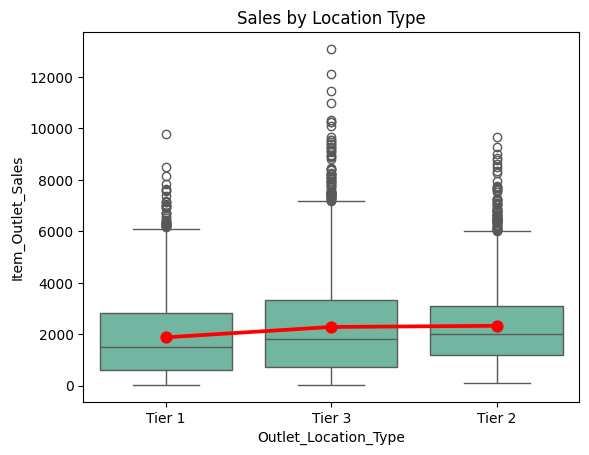

In [ ]:
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by Location Type")
sns.pointplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.show()


/tmp/ipython-input-549-511339389.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


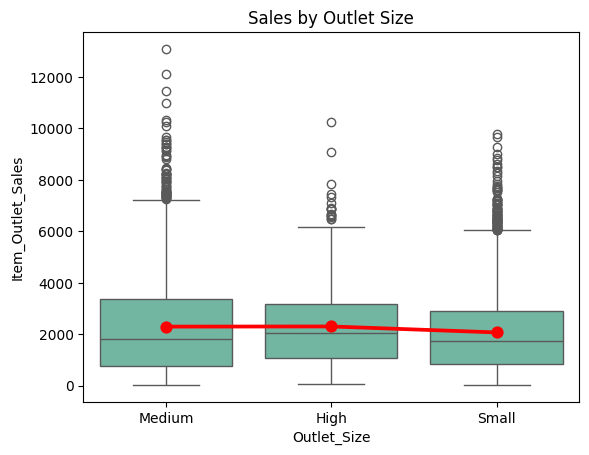

In [ ]:
sns.boxplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by Outlet Size")
sns.pointplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.show()

Creating Additional Features

In [ ]:
# Categorizing items
item_type_map = {
    'Dairy': 'Perishables',
    'Meat': 'Perishables',
    'Fruits and Vegetables': 'Perishables',
    'Seafood': 'Perishables',

    'Soft Drinks': 'Beverages',
    'Hard Drinks': 'Beverages',

    'Snack Foods': 'Processed Foods',
    'Frozen Foods': 'Processed Foods',
    'Baking Goods': 'Processed Foods',
    'Breakfast': 'Processed Foods',
    'Starchy Foods': 'Processed Foods',
    'Breads': 'Processed Foods',
    'Canned': 'Processed Foods',

    'Household': 'Non-Food',
    'Health and Hygiene': 'Non-Food',

    'Others': 'Misc'
}


In [ ]:
df_train['Item_Type_Cluster'] = df_train['Item_Type'].map(item_type_map)
df_test['Item_Type_Cluster'] = df_test['Item_Type'].map(item_type_map)

Feature: Is_Misc_Item

In [ ]:
df_train['Is_Misc_Item'] = (df_train['Item_Type'] == 'Others').astype(int)
df_test['Is_Misc_Item'] = (df_test['Item_Type'] == 'Others').astype(int)

Feature - outlet_type_item_type

In [ ]:
# Creating new feature : outlet_type_item_type
df_train['outlet_type_item_type'] = df_train['Outlet_Type'].astype(str) + '_' + df_train['Item_Type_Cluster'].astype(str)
df_test['outlet_type_item_type'] = df_test['Outlet_Type'].astype(str) + '_' + df_test['Item_Type_Cluster'].astype(str)


/tmp/ipython-input-554-214174585.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='outlet_type_item_type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


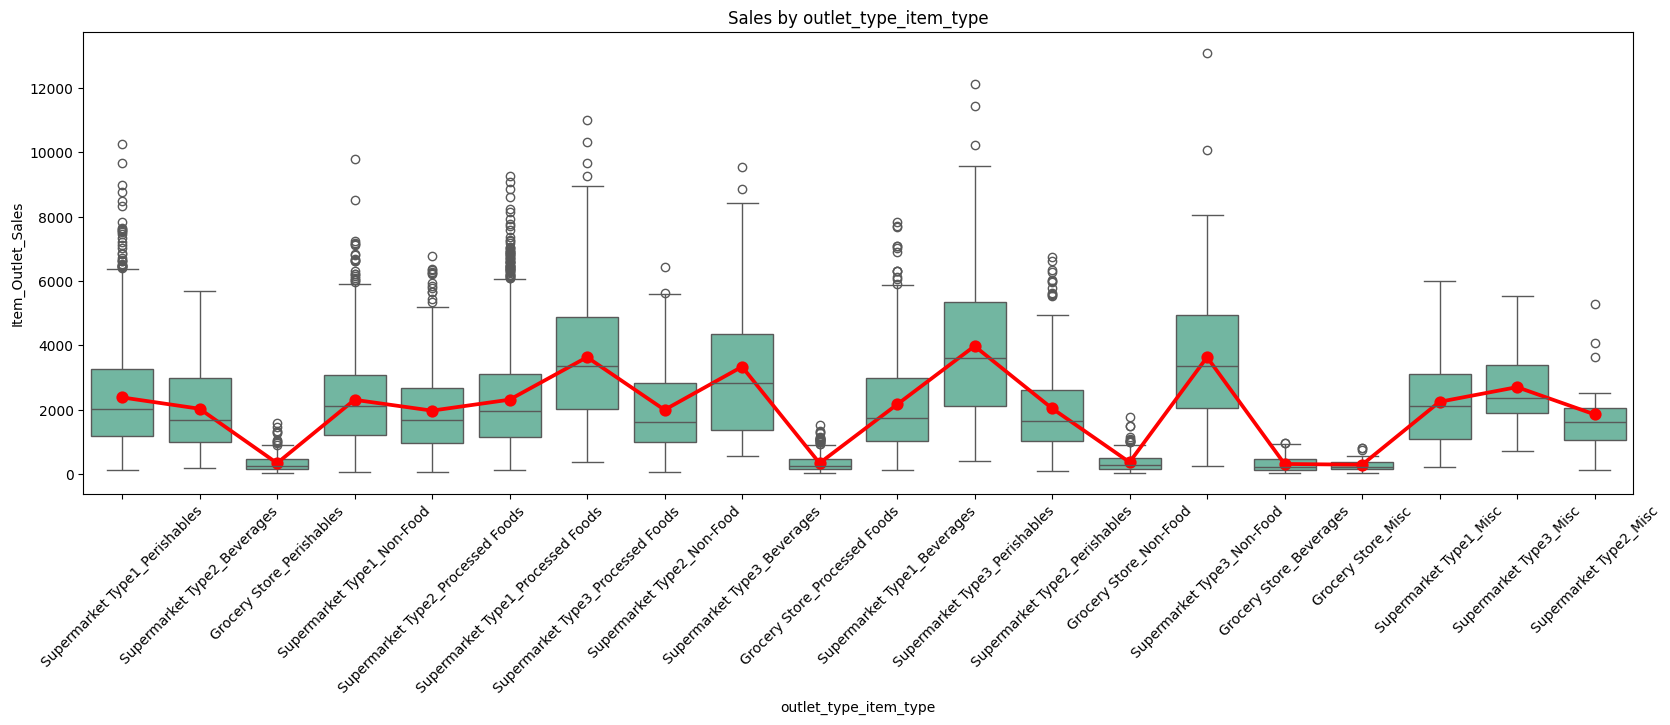

In [ ]:

plt.figure(figsize=(20, 6))
sns.boxplot(x='outlet_type_item_type', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by outlet_type_item_type")
sns.pointplot(x='outlet_type_item_type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.xticks(rotation=45)
plt.show()

Feature : outlet_location_outlet_type_item_type

In [ ]:
# Creating new feature : outlet_location_outlet_type_item_type
df_train['outlet_location_outlet_type_item_type'] = df_train['Outlet_Location_Type'].astype(str)+'_'+df_train['Outlet_Type'].astype(str) + '_' + df_train['Item_Type_Cluster'].astype(str)
df_test['outlet_location_outlet_type_item_type'] = df_test['Outlet_Location_Type'].astype(str)+'_'+df_test['Outlet_Type'].astype(str) + '_' + df_test['Item_Type_Cluster'].astype(str)


/tmp/ipython-input-556-2553773813.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='outlet_location_outlet_type_item_type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


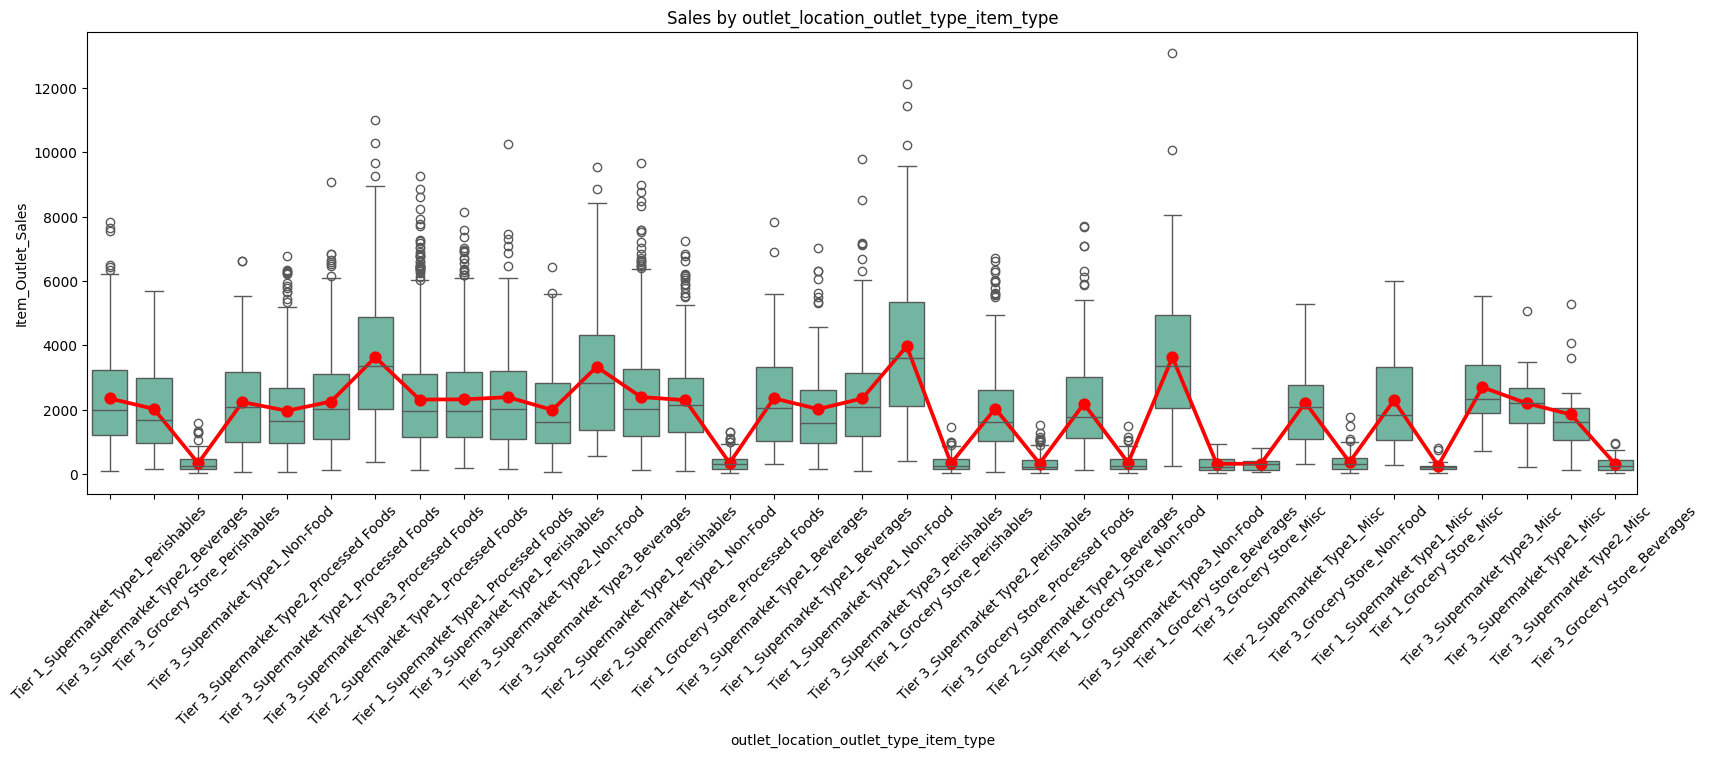

In [ ]:

plt.figure(figsize=(20, 6))
sns.boxplot(x='outlet_location_outlet_type_item_type', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by outlet_location_outlet_type_item_type")
sns.pointplot(x='outlet_location_outlet_type_item_type', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Creating new feature : outlet_location_outlet_type_item_type_item_fat_content
df_train['outlet_location_outlet_type_item_type_item_fat_content'] = df_train['Outlet_Location_Type'].astype(str)+'_'+df_train['Outlet_Type'].astype(str) + '_' + df_train['Item_Type_Cluster'].astype(str)+'_' +df_train['Item_Fat_Content']
df_test['outlet_location_outlet_type_item_type_item_fat_content'] = df_test['Outlet_Location_Type'].astype(str)+'_'+df_test['Outlet_Type'].astype(str) + '_' + df_test['Item_Type_Cluster'].astype(str)+'_' +df_test['Item_Fat_Content']

/tmp/ipython-input-558-146844654.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='outlet_location_outlet_type_item_type_item_fat_content', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


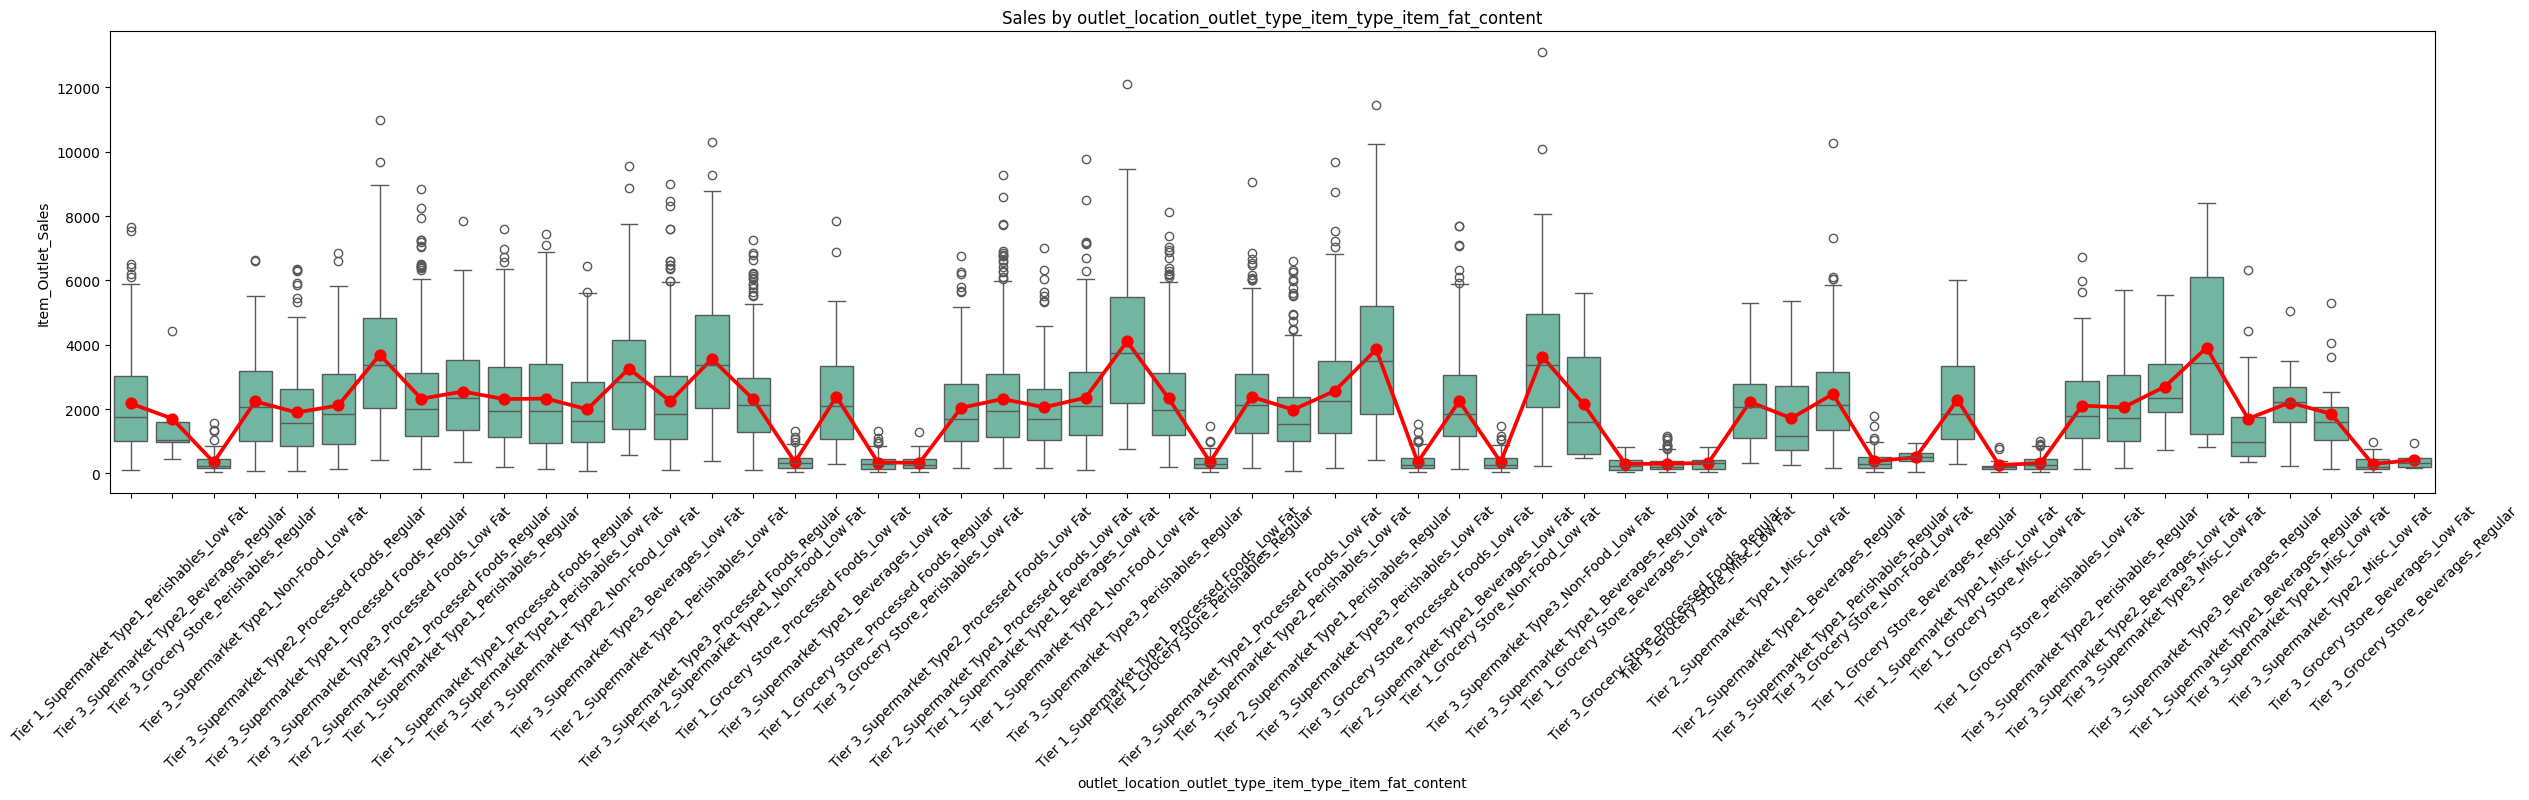

In [ ]:

plt.figure(figsize=(30, 6))
sns.boxplot(x='outlet_location_outlet_type_item_type_item_fat_content', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by outlet_location_outlet_type_item_type_item_fat_content")
sns.pointplot(x='outlet_location_outlet_type_item_type_item_fat_content', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# df_train['outlet_location_outlet_type_item_type_item_fat_content'].value_counts()


Feature: Outlet_Age

In [ ]:

df_train['Outlet_Age'] = datetime.now().year - df_train['Outlet_Establishment_Year']
df_test['Outlet_Age'] = datetime.now().year - df_test['Outlet_Establishment_Year']


In [ ]:
df_train.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,...,Item_Code,Log_Sales,Is_Visibility_Zero,Log_Visibility,Item_Type_Cluster,Is_Misc_Item,outlet_type_item_type,outlet_location_outlet_type_item_type,outlet_location_outlet_type_item_type_item_fat_content,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,...,FD,8.225808,0,0.015920,Perishables,0,Supermarket Type1_Perishables,Tier 1_Supermarket Type1_Perishables,Tier 1_Supermarket Type1_Perishables_Low Fat,26
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,...,DR,6.096776,0,0.019095,Beverages,0,Supermarket Type2_Beverages,Tier 3_Supermarket Type2_Beverages,Tier 3_Supermarket Type2_Beverages_Regular,16


Feature: Item_MRP_Bins

In [ ]:
df_train['Item_MRP_Bin'] = pd.cut(
    df_train['Item_MRP'],
    bins=[0, 70, 140, 200, df_train['Item_MRP'].max()],
    labels=['Low', 'Medium', 'High', 'Very High']
)

df_test['Item_MRP_Bin'] = pd.cut(
    df_test['Item_MRP'],
    bins=[0, 70, 140, 200, df_train['Item_MRP'].max()],
    labels=['Low', 'Medium', 'High', 'Very High']
)



In [ ]:
df_train['Item_MRP_Bin'].value_counts()

,count
Item_MRP_Bin,
High,2964
Medium,2778
Very High,1440
Low,1341


Feature: Item_Profile

In [ ]:
df_train['Item_Identifier'].value_counts()

,count
Item_Identifier,
FDW13,10
FDG33,10
FDX31,9
FDT07,9
NCY18,9
...,...
FDO33,1
FDK57,1
FDT35,1


In [ ]:
df_train['Item_Profile'] = (df_train['Item_Code'] + '_' + df_train['Item_Type'] + '_' + df_train['Item_Type_Cluster'])
df_test['Item_Profile'] = (df_test['Item_Code'] + '_' + df_test['Item_Type'] + '_' + df_test['Item_Type_Cluster'])



In [ ]:
df_train['Item_Profile'].value_counts()

,count
Item_Profile,
FD_Fruits and Vegetables_Perishables,1232
FD_Snack Foods_Processed Foods,1200
NC_Household_Non-Food,910
FD_Frozen Foods_Processed Foods,856
FD_Canned_Processed Foods,649
FD_Baking Goods_Processed Foods,648
FD_Dairy_Perishables,542
NC_Health and Hygiene_Non-Food,520
DR_Soft Drinks_Beverages,445


The Feature Item Profile has significantly improved the frequency of categories. There are few categories which still have low count. We will label these as Rare as they occur in a very small number.

Feature : Item_Profile_Freq_Bin

In [ ]:
profile_counts = df_train['Item_Profile'].value_counts()
df_train['Item_Profile_Freq'] = df_train['Item_Profile'].map(profile_counts)
df_test['Item_Profile_Freq'] = df_test['Item_Profile'].map(profile_counts)
df_test['Item_Profile_Freq'].fillna(0, inplace=True)

bins = [0, 5, 15, 30, profile_counts.max()]
labels = ['Very Rare', 'Rare', 'Common', 'Very Common']

df_train['Item_Profile_Freq_Bin'] = pd.cut(df_train['Item_Profile_Freq'], bins=bins, labels=labels)
df_test['Item_Profile_Freq_Bin'] = pd.cut(df_test['Item_Profile_Freq'], bins=bins, labels=labels)



/tmp/ipython-input-567-1817554612.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Item_Profile_Freq'].fillna(0, inplace=True)


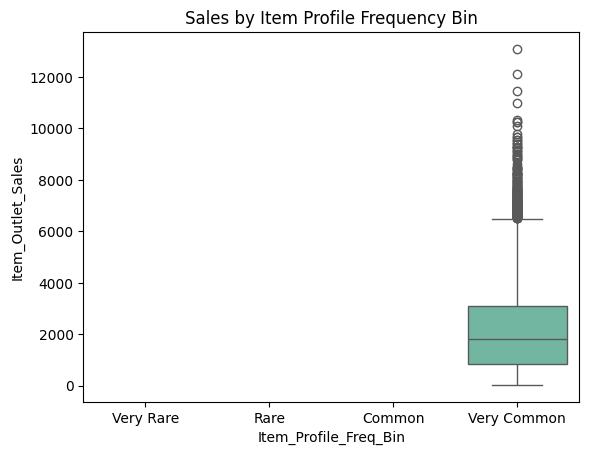

In [ ]:
sns.boxplot(x='Item_Profile_Freq_Bin', y='Item_Outlet_Sales', data=df_train)
plt.title('Sales by Item Profile Frequency Bin')
plt.show()


Conclusion: The feature above is not a strong feature for predicting the sales as the median across all categories is similar.

Feature: Freq_Bin_Item_Cluster

We try to find out if the feature item_profile_freq_bin together with some other feature shows good variance in sales.

<Axes: xlabel='Item_Profile_Freq_Bin', ylabel='Item_Outlet_Sales'>

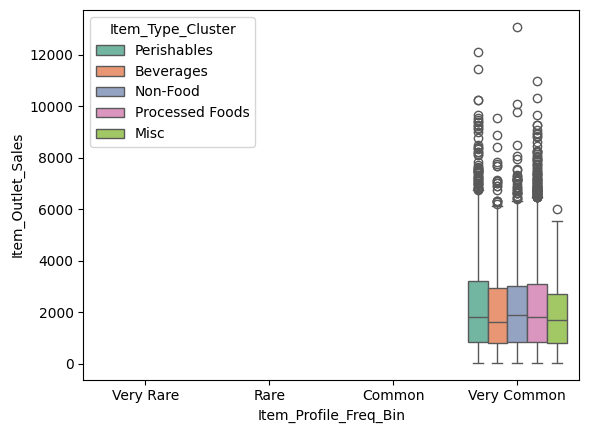

In [ ]:
sns.boxplot(x='Item_Profile_Freq_Bin', y='Item_Outlet_Sales', hue='Item_Type_Cluster', data=df_train)


<Axes: xlabel='Item_Profile_Freq_Bin', ylabel='Item_Outlet_Sales'>

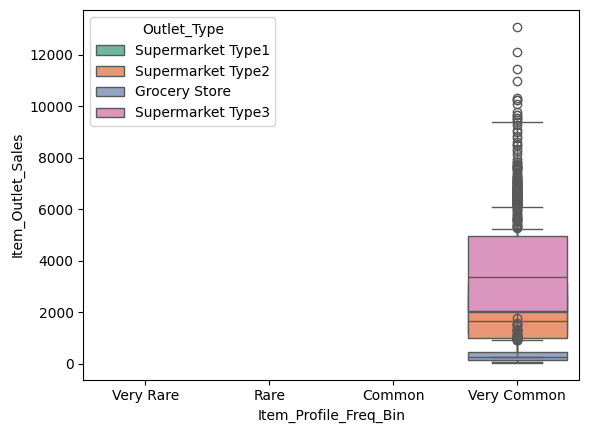

In [ ]:
sns.boxplot(x='Item_Profile_Freq_Bin', y='Item_Outlet_Sales', hue='Outlet_Type', data=df_train)


Conclusion: Good Variance is observed when combined with the feature Outlet_type

In [ ]:
df_train['Freq_Bin_Item_Cluster'] = df_train['Item_Profile_Freq_Bin'].astype(str) + '_' + df_train['Outlet_Type']
df_test['Freq_Bin_Item_Cluster'] = df_test['Item_Profile_Freq_Bin'].astype(str) + '_' + df_test['Outlet_Type']


/tmp/ipython-input-572-3132796127.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Freq_Bin_Item_Cluster', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


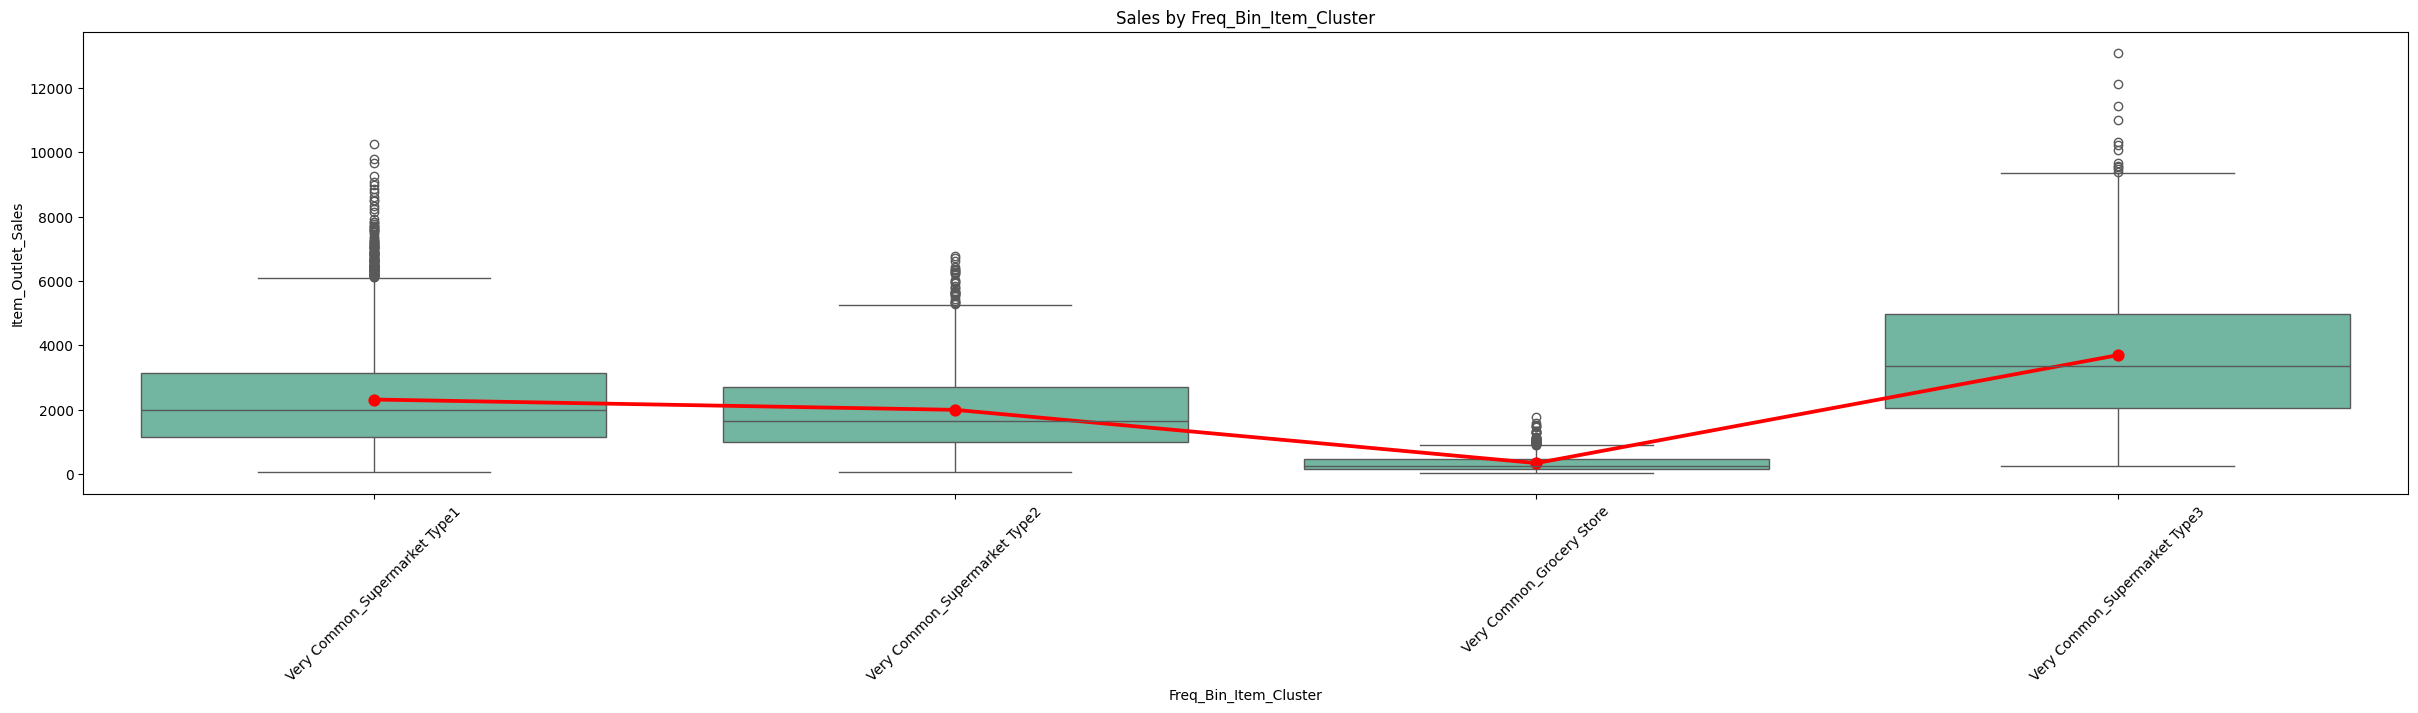

In [ ]:

plt.figure(figsize=(30, 6))
sns.boxplot(x='Freq_Bin_Item_Cluster', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by Freq_Bin_Item_Cluster")
sns.pointplot(x='Freq_Bin_Item_Cluster', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.xticks(rotation=45)
plt.show()

Visualizing : Item_Profile_Freq_Bin

/tmp/ipython-input-573-2905675163.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='Item_Profile_Freq_Bin', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)


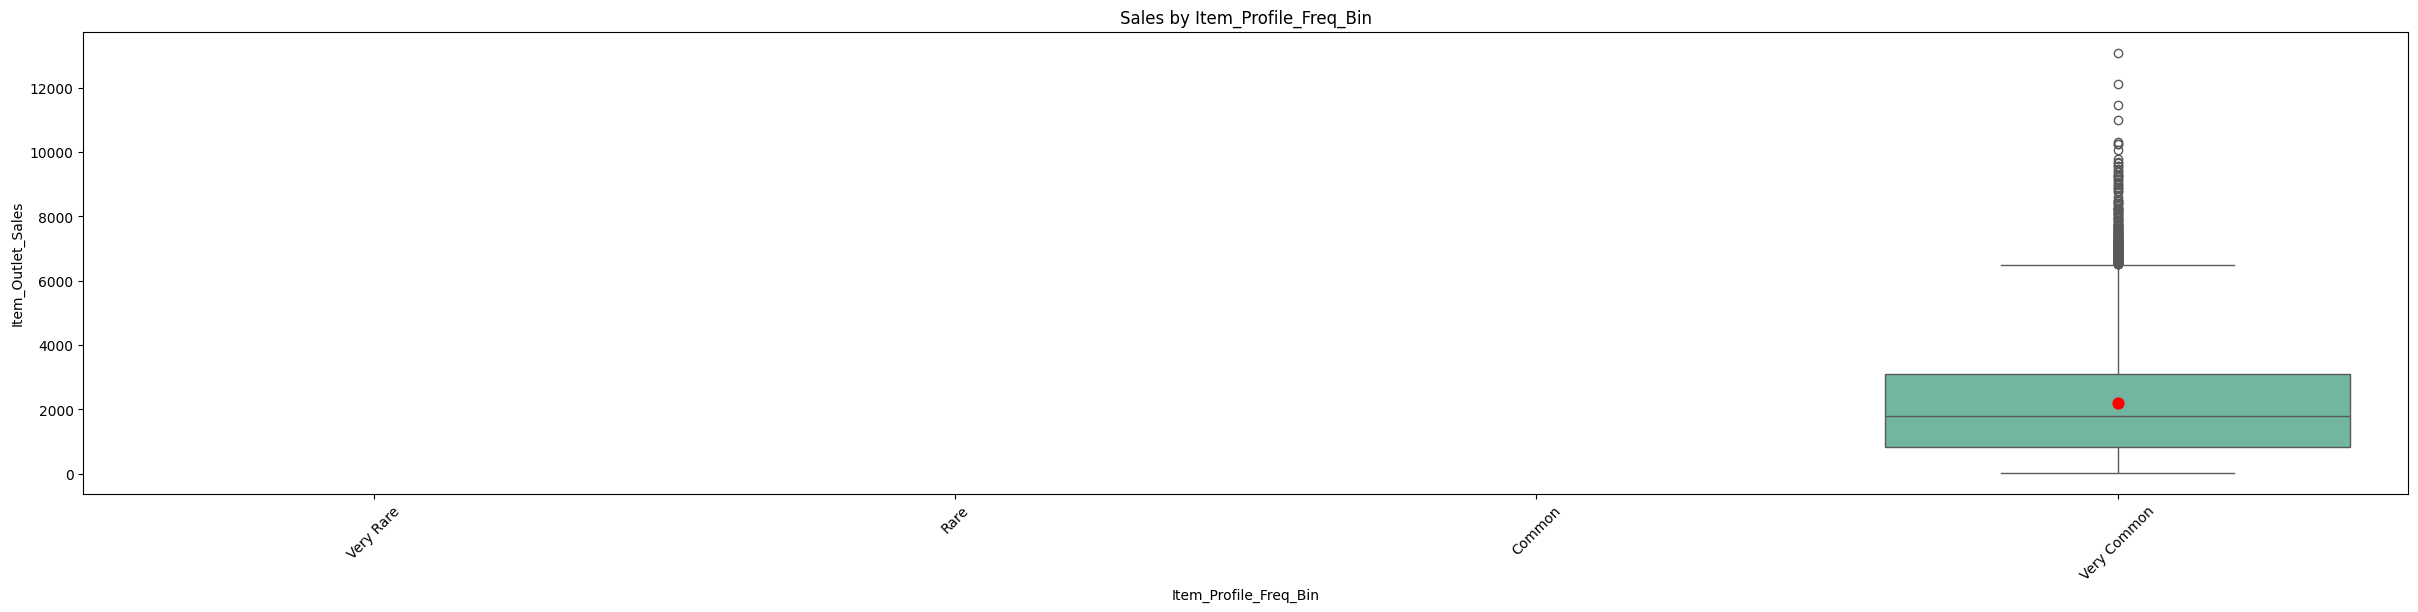

In [ ]:

plt.figure(figsize=(30, 6))
sns.boxplot(x='Item_Profile_Freq_Bin', y='Item_Outlet_Sales', data=df_train)
plt.title("Sales by Item_Profile_Freq_Bin")
sns.pointplot(x='Item_Profile_Freq_Bin', y='Item_Outlet_Sales', data=df_train, color='red', ci=None)
plt.xticks(rotation=45)
plt.show()

Feature: Median_Sale_per_Outlet

In [ ]:
median_sales_per_outlet = df_train.groupby('Outlet_Identifier')['Item_Outlet_Sales'].median()

df_train['Median_Sales_per_Outlet'] = df_train['Outlet_Identifier'].map(median_sales_per_outlet)
df_test['Median_Sales_per_Outlet'] = df_test['Outlet_Identifier'].map(median_sales_per_outlet)
df_test['Median_Sales_per_Outlet'].fillna(df_train['Item_Outlet_Sales'].median(), inplace=True)


/tmp/ipython-input-574-1345152370.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Median_Sales_per_Outlet'].fillna(df_train['Item_Outlet_Sales'].median(), inplace=True)


Feature: Median_Log_Sale_per_Outlet

In [ ]:
# Create median log sales per outlet from train data
median_log_sales_per_outlet = df_train.groupby('Outlet_Identifier')['Log_Sales'].median()

# Map to both train and test
df_train['Median_Log_Sales_per_Outlet'] = df_train['Outlet_Identifier'].map(median_log_sales_per_outlet)
df_test['Median_Log_Sales_per_Outlet'] = df_test['Outlet_Identifier'].map(median_log_sales_per_outlet)
df_test['Median_Log_Sales_per_Outlet'].fillna(df_train['Log_Sales'].median(), inplace=True)


/tmp/ipython-input-575-2989527253.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Median_Log_Sales_per_Outlet'].fillna(df_train['Log_Sales'].median(), inplace=True)


Feature: Median_Log_Sales_per_Item_Cluster

In [ ]:
df_train['Item_Type_Cluster'].value_counts()

,count
Item_Type_Cluster,
Processed Foods,3862
Perishables,2403
Non-Food,1430
Beverages,659
Misc,169


In [ ]:
# Compute median log sales per item cluster
median_log_sales_per_cluster = df_train.groupby('Item_Type_Cluster')['Log_Sales'].median()

# Map to train and test
df_train['Median_Log_Sales_per_Item_Cluster'] = df_train['Item_Type_Cluster'].map(median_log_sales_per_cluster)
df_test['Median_Log_Sales_per_Item_Cluster'] = df_test['Item_Type_Cluster'].map(median_log_sales_per_cluster)
df_test['Median_Log_Sales_per_Item_Cluster'].fillna(df_train['Log_Sales'].median(), inplace=True)


/tmp/ipython-input-577-2360320680.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Median_Log_Sales_per_Item_Cluster'].fillna(df_train['Log_Sales'].median(), inplace=True)


Feature: Median_Sales_Per_Cluster

In [ ]:
# Compute median log sales per item cluster
median_sales_per_cluster = df_train.groupby('Item_Type_Cluster')['Item_Outlet_Sales'].median()

# Map to train and test
df_train['Median_Sales_per_Item_Cluster'] = df_train['Item_Type_Cluster'].map(median_sales_per_cluster)
df_test['Median_Sales_per_Item_Cluster'] = df_test['Item_Type_Cluster'].map(median_sales_per_cluster)
df_test['Median_Sales_per_Item_Cluster'].fillna(df_train['Item_Outlet_Sales'].median(), inplace=True)

/tmp/ipython-input-578-3602507226.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Median_Sales_per_Item_Cluster'].fillna(df_train['Item_Outlet_Sales'].median(), inplace=True)


Feature: Outlet Sales Tier

In [ ]:
median_sales_per_outlet

,Item_Outlet_Sales
Outlet_Identifier,
OUT010,250.3408
OUT013,2050.6640
OUT017,2005.0567
OUT018,1655.1788
OUT019,265.3213
OUT027,3364.9532
OUT035,2109.2544
OUT045,1834.9448
OUT046,1945.8005


In [ ]:
median_sales_series = pd.Series(median_sales_per_outlet)

# Use qcut to create 3 quantile-based tiers
sales_tiers = pd.qcut(median_sales_series, q=3, labels=['Low', 'Medium', 'High'])

# Create a mapping: Outlet ID → Tier
outlet_sales_tier_map = sales_tiers.to_dict()

# Create the new feature
df_train['Outlet_Sales_Tier'] = df_train['Outlet_Identifier'].map(outlet_sales_tier_map)
df_test['Outlet_Sales_Tier'] = df_test['Outlet_Identifier'].map(outlet_sales_tier_map)
df_test['Outlet_Sales_Tier'].fillna('Medium', inplace=True)


/tmp/ipython-input-580-1460699196.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Outlet_Sales_Tier'].fillna('Medium', inplace=True)


Feature: MRP_Rank_in_Outlet(Ranking the item in the outlet based on its MRP)

In [ ]:
df_train['MRP_Rank_in_Outlet'] = df_train.groupby('Outlet_Identifier')['Item_MRP'].rank()
df_test['MRP_Rank_in_Outlet'] = df_test.groupby('Outlet_Identifier')['Item_MRP'].rank()


Feature: Item_Type_Popularity

In [ ]:
# Get total sales
item_total_sales = df_train.groupby('Item_Type_Cluster')['Item_Outlet_Sales'].sum()

# Rank them (higher sales = higher rank, rank 1 = most popular)
item_sales_rank = item_total_sales.rank(ascending=False).astype(int)

# Map to train and test
df_train['Item_Type_Popularity_Rank'] = df_train['Item_Type_Cluster'].map(item_sales_rank)
df_test['Item_Type_Popularity_Rank'] = df_test['Item_Type_Cluster'].map(item_sales_rank)

# Fill missing ranks in test (for unseen clusters)
df_test['Item_Type_Popularity_Rank'] = df_test['Item_Type_Popularity_Rank'].fillna(item_sales_rank.median())


Feature: MRP_Per_Year

In [ ]:
df_train['MRP_per_Year'] = df_train['Item_MRP'] / df_train['Outlet_Age'].replace(0, np.nan)
df_test['MRP_per_Year'] = df_test['Item_MRP'] / df_test['Outlet_Age'].replace(0, np.nan)

df_train['MRP_per_Year'].fillna(df_train['MRP_per_Year'].median(), inplace=True)
df_test['MRP_per_Year'].fillna(df_train['MRP_per_Year'].median(), inplace=True)


/tmp/ipython-input-583-217251847.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['MRP_per_Year'].fillna(df_train['MRP_per_Year'].median(), inplace=True)
/tmp/ipython-input-583-217251847.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

Feature : Outlet_Cluster_Volume_Rank

In [ ]:
# Count the number of times each item cluster is sold in each outlet
cluster_volume = df_train.groupby(['Item_Type_Cluster', 'Outlet_Identifier']).size().reset_index(name='Cluster_Sales_Count')

# Rank outlets within each item cluster based on count
cluster_volume['Outlet_Cluster_Volume_Rank'] = cluster_volume.groupby('Item_Type_Cluster')['Cluster_Sales_Count'] \
                                                              .rank(method='dense', ascending=False)

# Merge into train and test
df_train = df_train.merge(
    cluster_volume[['Item_Type_Cluster', 'Outlet_Identifier', 'Outlet_Cluster_Volume_Rank']],
    on=['Item_Type_Cluster', 'Outlet_Identifier'],
    how='left'
)

df_test = df_test.merge(
    cluster_volume[['Item_Type_Cluster', 'Outlet_Identifier', 'Outlet_Cluster_Volume_Rank']],
    on=['Item_Type_Cluster', 'Outlet_Identifier'],
    how='left'
)

# Fallback: use cluster-wise median rank
cluster_median_rank = cluster_volume.groupby('Item_Type_Cluster')['Outlet_Cluster_Volume_Rank'].median()

df_test['Outlet_Cluster_Volume_Rank'] = df_test.apply(
    lambda row: cluster_median_rank.get(row['Item_Type_Cluster'])
    if pd.isna(row['Outlet_Cluster_Volume_Rank'])
    else row['Outlet_Cluster_Volume_Rank'], axis=1
)


Visualizing Item_Type occurences in the dataset

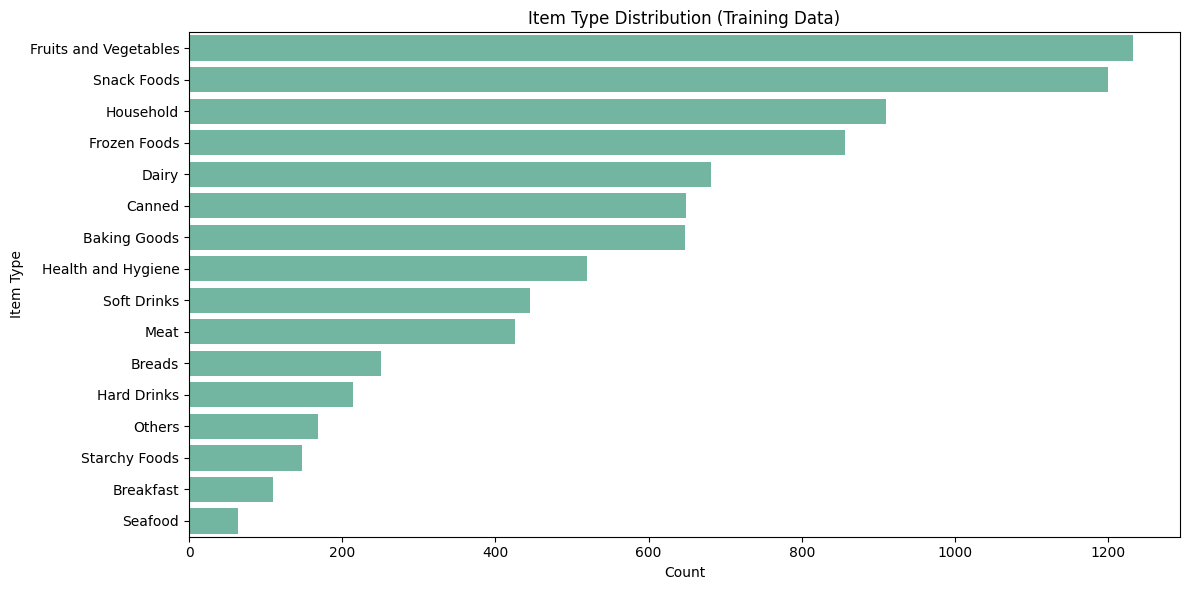

In [ ]:
# On Train Data
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='Item_Type', order=df_train['Item_Type'].value_counts().index)
plt.title("Item Type Distribution (Training Data)")
plt.xlabel("Count")
plt.ylabel("Item Type")
plt.tight_layout()
plt.show()


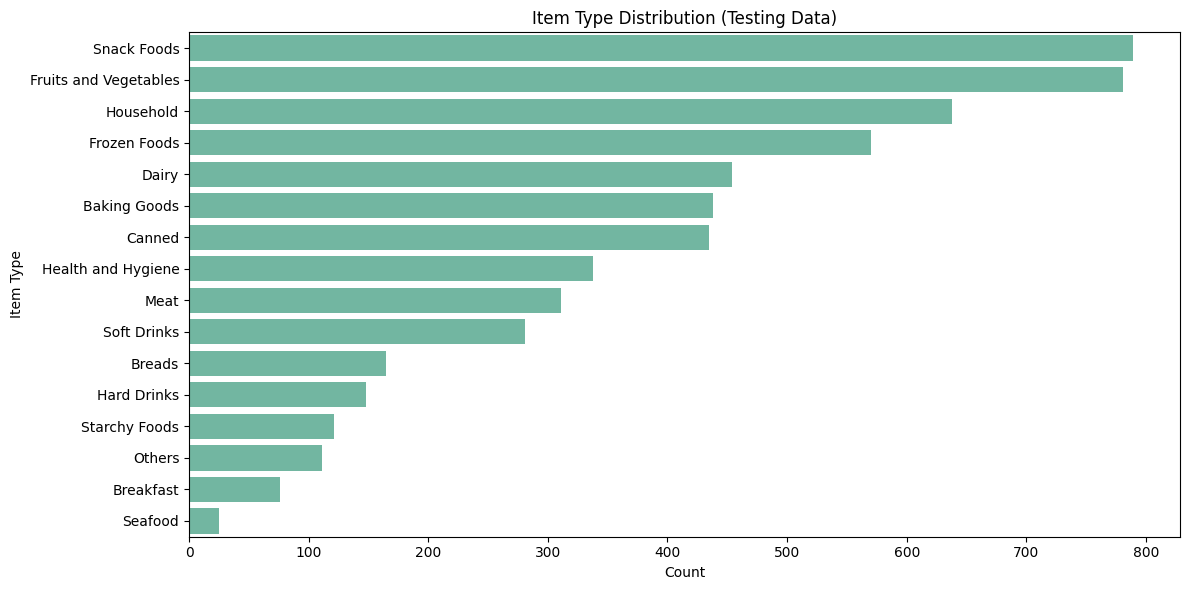

In [ ]:
#On Test Data
plt.figure(figsize=(12, 6))
sns.countplot(data=df_test, y='Item_Type', order=df_test['Item_Type'].value_counts().index)
plt.title("Item Type Distribution (Testing Data)")
plt.xlabel("Count")
plt.ylabel("Item Type")
plt.tight_layout()
plt.show()


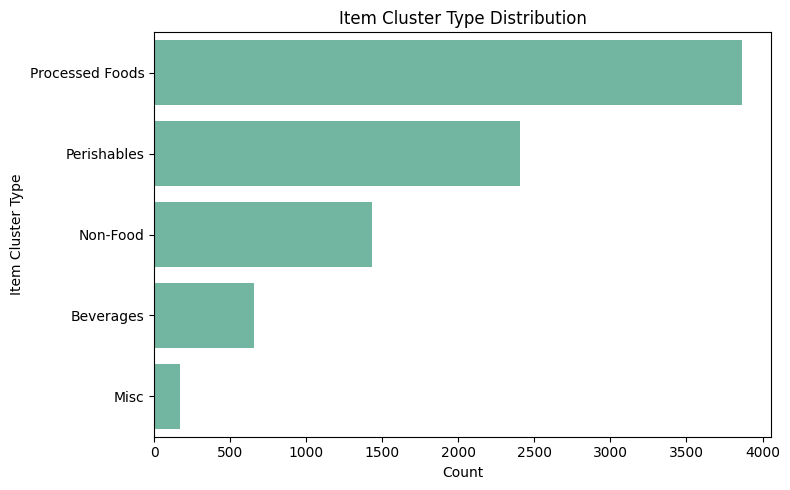

In [ ]:
# Train Set
plt.figure(figsize=(8, 5))
sns.countplot(data=df_train, y='Item_Type_Cluster', order=df_train['Item_Type_Cluster'].value_counts().index)
plt.title("Item Cluster Type Distribution")
plt.xlabel("Count")
plt.ylabel("Item Cluster Type")
plt.tight_layout()
plt.show()


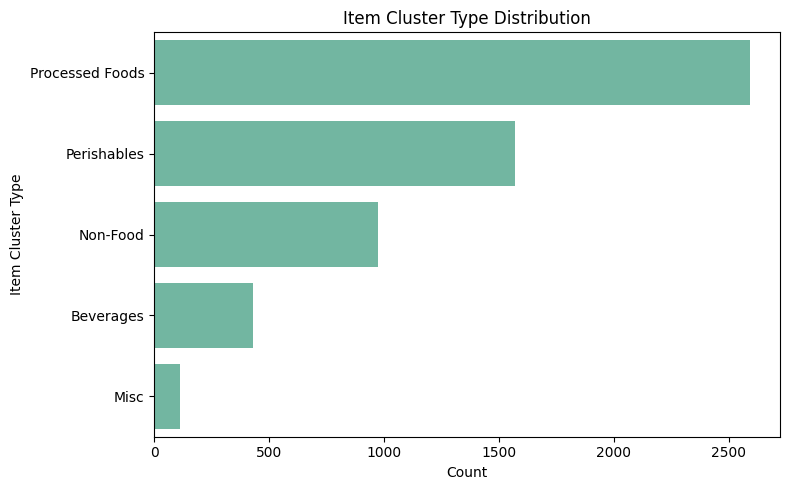

In [ ]:
# Test Set
plt.figure(figsize=(8, 5))
sns.countplot(data=df_test, y='Item_Type_Cluster', order=df_test['Item_Type_Cluster'].value_counts().index)
plt.title("Item Cluster Type Distribution")
plt.xlabel("Count")
plt.ylabel("Item Cluster Type")
plt.tight_layout()
plt.show()


We see above few item_types are under represented. We group them into rare category.

Feature : ITem_CLuster__Demand_Rank

In [ ]:
# Count frequency of each Item_Type_Cluster
cluster_counts = df_train['Item_Type_Cluster'].value_counts()

# Create rank: most frequent = rank 1
cluster_demand_rank = cluster_counts.rank(ascending=False, method='dense').astype(int).to_dict()

# Map to new column in train and test
df_train['Item_Cluster_Demand_Rank'] = df_train['Item_Type_Cluster'].map(cluster_demand_rank)
df_test['Item_Cluster_Demand_Rank'] = df_test['Item_Type_Cluster'].map(cluster_demand_rank)


Feature: Item_Identifier_Demand_Rank

In [ ]:
# Count frequency of each Item_Identifier
identifier_counts = df_train['Item_Identifier'].value_counts()

# Rank: highest frequency = rank 1
identifier_demand_rank = identifier_counts.rank(ascending=False, method='dense').astype(int).to_dict()

# Map to new columns
df_train['Item_Identifier_Demand_Rank'] = df_train['Item_Identifier'].map(identifier_demand_rank)
df_test['Item_Identifier_Demand_Rank'] = df_test['Item_Identifier'].map(identifier_demand_rank)
median_rank = np.median(list(identifier_demand_rank.values()))
df_test['Item_Identifier_Demand_Rank'] = df_test['Item_Identifier_Demand_Rank'].fillna(median_rank)


Visualizing the distribution of items across different tier cities

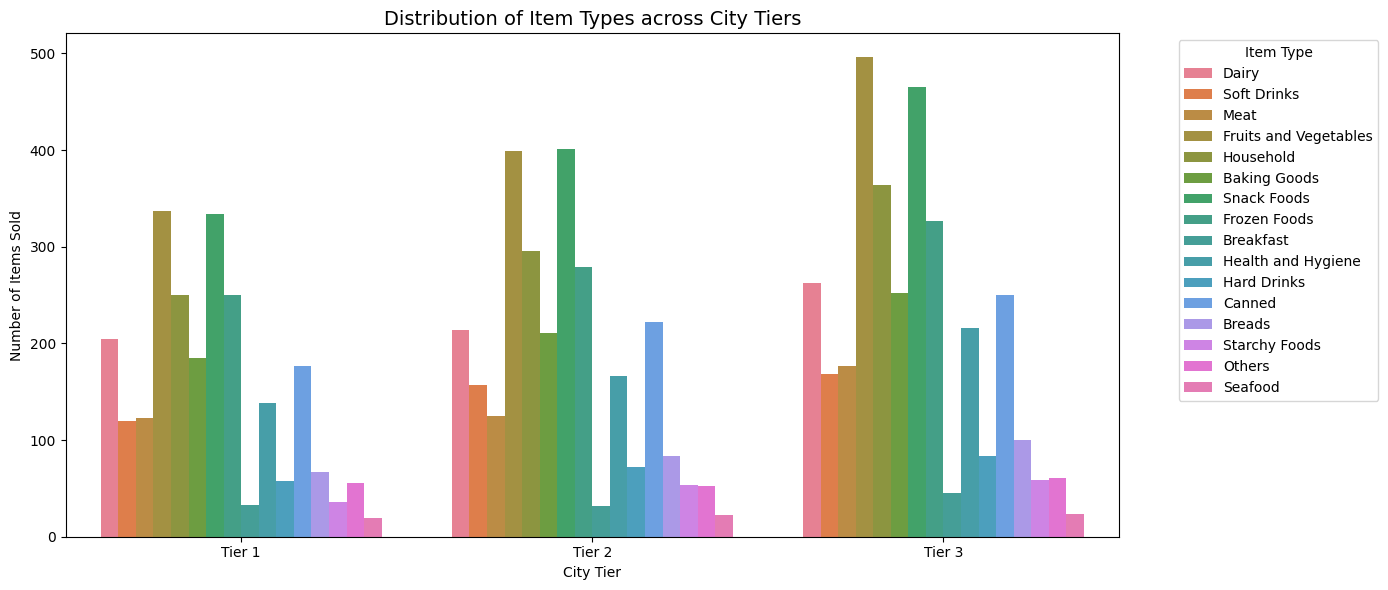

In [ ]:
plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Better color palette
sns.countplot(
    data=df_train,
    x='Outlet_Location_Type',
    hue='Item_Type',
    order=['Tier 1', 'Tier 2', 'Tier 3']
)
plt.title("Distribution of Item Types across City Tiers", fontsize=14)
plt.xlabel("City Tier")
plt.ylabel("Number of Items Sold")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Item Type")
plt.tight_layout()
plt.show()


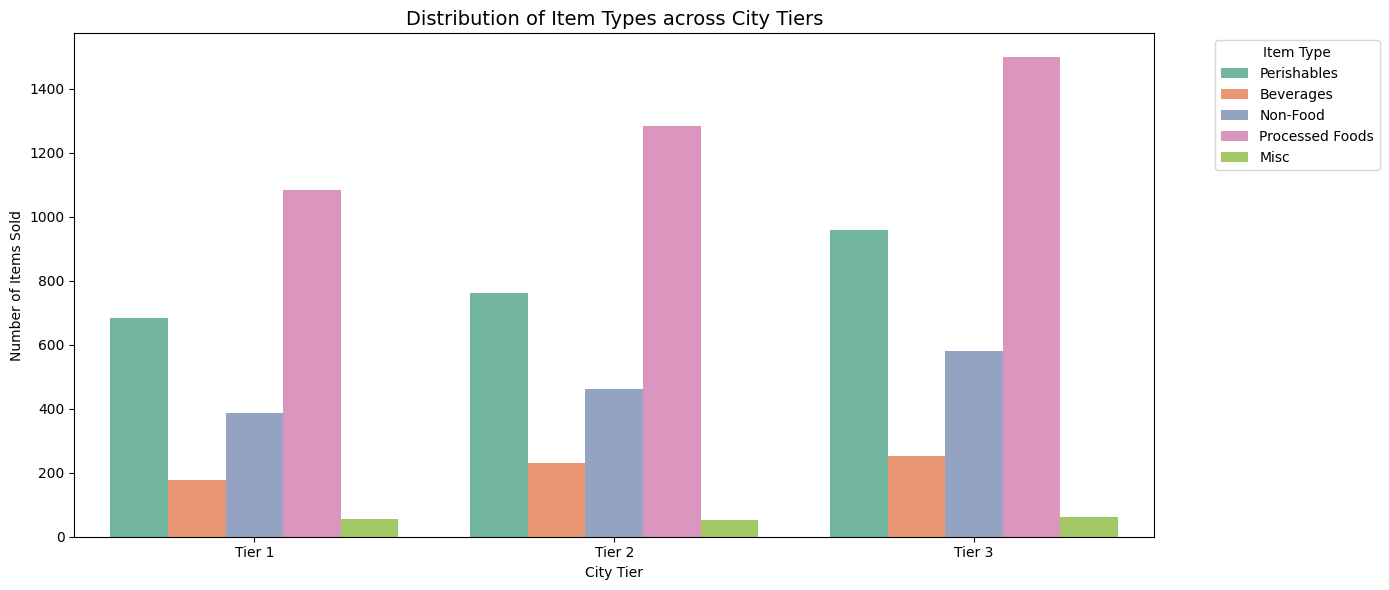

In [ ]:
plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Better color palette
sns.countplot(
    data=df_train,
    x='Outlet_Location_Type',
    hue='Item_Type_Cluster',
    order=['Tier 1', 'Tier 2', 'Tier 3']
)
plt.title("Distribution of Item Types across City Tiers", fontsize=14)
plt.xlabel("City Tier")
plt.ylabel("Number of Items Sold")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Item Type")
plt.tight_layout()
plt.show()


Feature: Median_Sales_Per_City_Tier

In [ ]:
# Calculate medians per city tier
city_sales_medians = df_train.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].median().to_dict()
city_log_sales_medians = df_train.groupby('Outlet_Location_Type')['Log_Sales'].median().to_dict()

# Map to new columns in both train and test
df_train['Median_Sales_Per_City_Tier'] = df_train['Outlet_Location_Type'].map(city_sales_medians)
df_train['Median_Log_Sales_Per_City_Tier'] = df_train['Outlet_Location_Type'].map(city_log_sales_medians)

df_test['Median_Sales_Per_City_Tier'] = df_test['Outlet_Location_Type'].map(city_sales_medians)
df_test['Median_Log_Sales_Per_City_Tier'] = df_test['Outlet_Location_Type'].map(city_log_sales_medians)


Item MRP Distribution across different Tier Cities

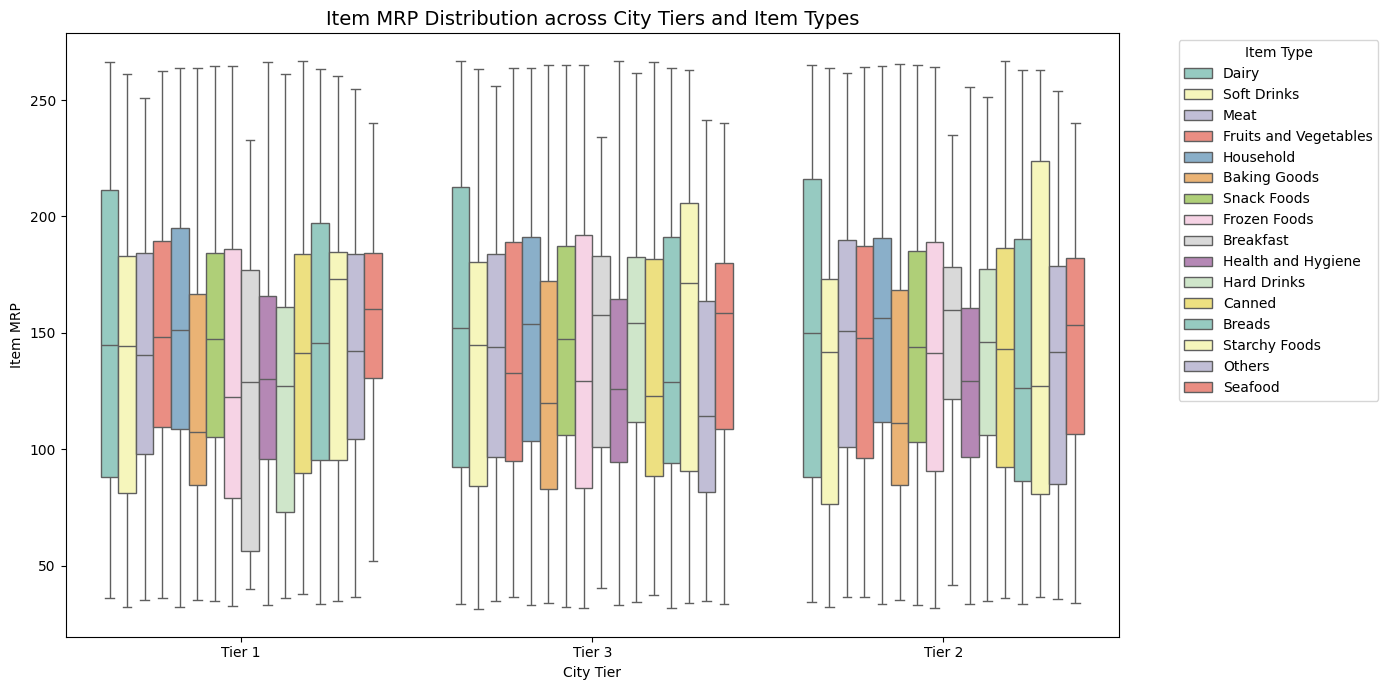

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_train,
    x='Outlet_Location_Type',
    y='Item_MRP',
    hue='Item_Type',
    showfliers=False,  # removes outlier dots for clarity
    palette='Set3'
)
plt.title("Item MRP Distribution across City Tiers and Item Types", fontsize=14)
plt.xlabel("City Tier")
plt.ylabel("Item MRP")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Item Type')
plt.tight_layout()
plt.show()


Item MRP Distribution across Outlet_Type and Item_Types

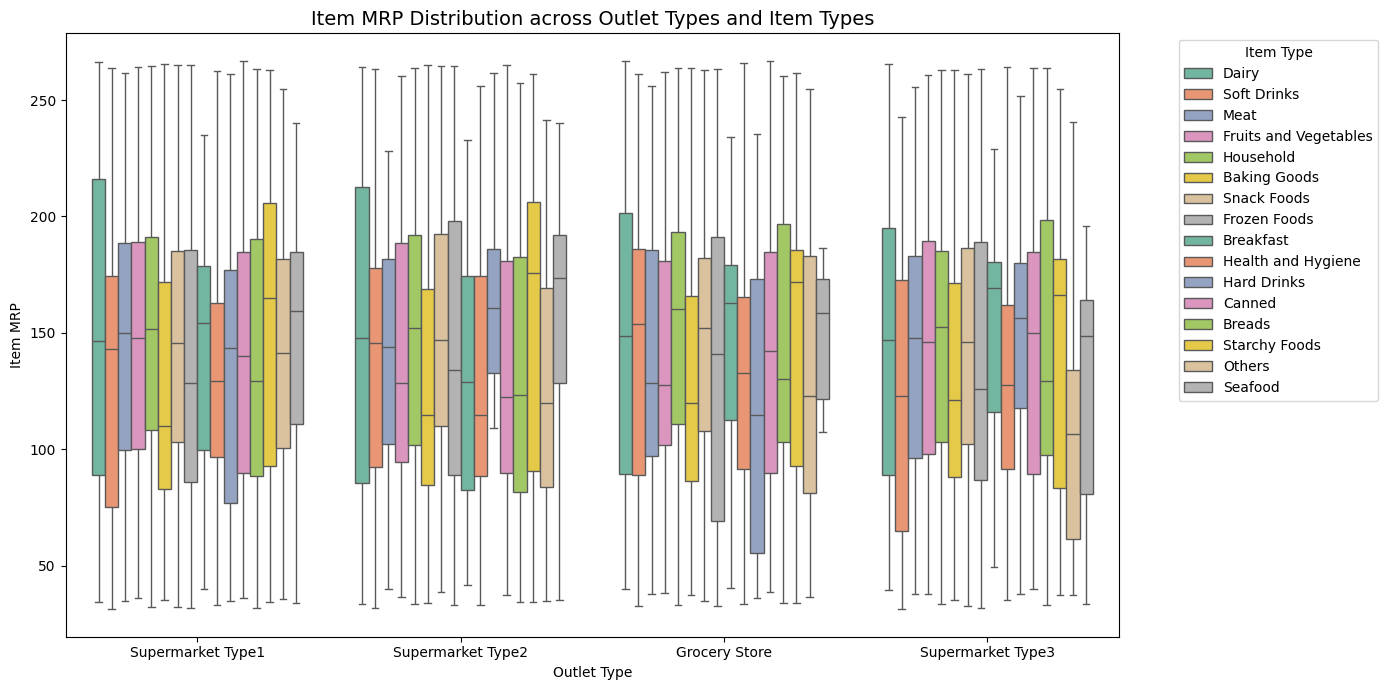

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_train,
    x='Outlet_Type',
    y='Item_MRP',
    hue='Item_Type',
    showfliers=False,
    palette='Set2'
)
plt.title("Item MRP Distribution across Outlet Types and Item Types", fontsize=14)
plt.xlabel("Outlet Type")
plt.ylabel("Item MRP")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Item Type')
plt.tight_layout()
plt.show()


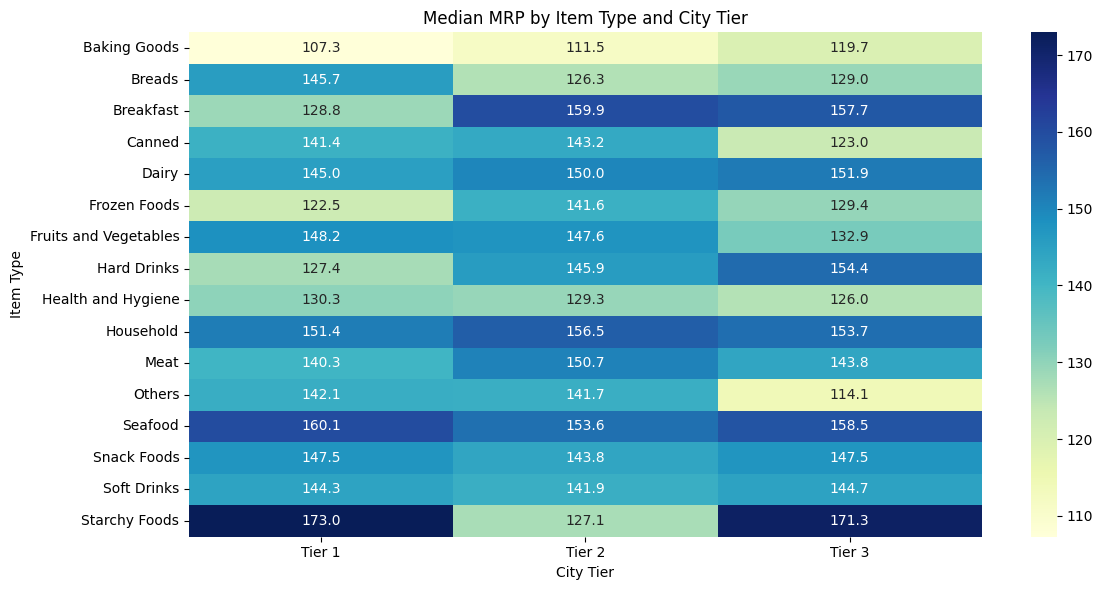

In [ ]:
pivot = df_train.pivot_table(
    index='Item_Type',
    columns='Outlet_Location_Type',
    values='Item_MRP',
    aggfunc='median'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title("Median MRP by Item Type and City Tier")
plt.xlabel("City Tier")
plt.ylabel("Item Type")
plt.tight_layout()
plt.show()


Feature - Median_MRP_ItemType_Per_Tier and MRP_Deviation_From_Tier_Median

In [ ]:
# Compute median MRP per (Item_Type, City Tier)
item_mrp_median_by_tier = df_train.groupby(['Item_Type', 'Outlet_Location_Type'])['Item_MRP'].median().to_dict()

# Define a function to fetch median MRP
def get_tier_median_mrp(row):
    return item_mrp_median_by_tier.get((row['Item_Type'], row['Outlet_Location_Type']), np.nan)

# Create feature in both train and test
df_train['Median_MRP_ItemType_Per_Tier'] = df_train.apply(get_tier_median_mrp, axis=1)
df_test['Median_MRP_ItemType_Per_Tier'] = df_test.apply(get_tier_median_mrp, axis=1)

# Create deviation feature
df_train['MRP_Deviation_From_Tier_Median'] = df_train['Item_MRP'] - df_train['Median_MRP_ItemType_Per_Tier']
df_test['MRP_Deviation_From_Tier_Median'] = df_test['Item_MRP'] - df_test['Median_MRP_ItemType_Per_Tier']
# Absolute difference
df_train['Abs_MRP_Deviation'] = df_train['MRP_Deviation_From_Tier_Median'].abs()
df_test['Abs_MRP_Deviation'] = df_test['MRP_Deviation_From_Tier_Median'].abs()



Fixing Item_Weights to ensure there is 1:1 mapping between Item_Identifier and Item_Weight

In [ ]:
# Step 1: Compute mode weight for each Item_Identifier
item_weight_mode = df_train.groupby('Item_Identifier')['Item_Weight'].agg(lambda x: x.mode().iloc[0])

# Step 2: function to apply mode
def apply_mode_weight(row):
    return item_weight_mode.get(row['Item_Identifier'], np.nan)  # fallback to NaN if item not found

# Step 3: Apply the function to both train and test sets
df_train['Item_Weight'] = df_train.apply(apply_mode_weight, axis=1)
df_test['Item_Weight'] = df_test.apply(apply_mode_weight, axis=1)

# Fill any remaining NaNs with overall mode
global_mode_weight = df_train['Item_Weight'].mode().iloc[0]
df_train['Item_Weight'].fillna(global_mode_weight, inplace=True)
df_test['Item_Weight'].fillna(global_mode_weight, inplace=True)


/tmp/ipython-input-598-1713388297.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Item_Weight'].fillna(global_mode_weight, inplace=True)
/tmp/ipython-input-598-1713388297.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

Feature: Median_Log_Sales_per_Item_OutletType

In [ ]:
# Median Log Sales per (Item_Type, Outlet_Type)
log_sales_grp = df_train.groupby(['Item_Type', 'Outlet_Type'])['Log_Sales'].median().reset_index()
log_sales_grp.rename(columns={'Log_Sales': 'Median_Log_Sales_per_Item_OutletType'}, inplace=True)

# Median Actual Sales per (Item_Type, Outlet_Type)
actual_sales_grp = df_train.groupby(['Item_Type', 'Outlet_Type'])['Item_Outlet_Sales'].median().reset_index()
actual_sales_grp.rename(columns={'Item_Outlet_Sales': 'Median_Sales_per_Item_OutletType'}, inplace=True)

# Merge both into train
df_train = df_train.merge(log_sales_grp, on=['Item_Type', 'Outlet_Type'], how='left')
df_train = df_train.merge(actual_sales_grp, on=['Item_Type', 'Outlet_Type'], how='left')

# Merge both into test
df_test = df_test.merge(log_sales_grp, on=['Item_Type', 'Outlet_Type'], how='left')
df_test = df_test.merge(actual_sales_grp, on=['Item_Type', 'Outlet_Type'], how='left')

# Fill missing (if any) in test with global medians
global_log_sales_median = df_train['Log_Sales'].median()
global_sales_median = df_train['Item_Outlet_Sales'].median()

df_test['Median_Log_Sales_per_Item_OutletType'].fillna(global_log_sales_median, inplace=True)
df_test['Median_Sales_per_Item_OutletType'].fillna(global_sales_median, inplace=True)


/tmp/ipython-input-599-745648941.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Median_Log_Sales_per_Item_OutletType'].fillna(global_log_sales_median, inplace=True)
/tmp/ipython-input-599-745648941.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

Feature: Median_Log_Sales_ItemCluster_OutletType

In [ ]:
# Compute the grouped median log sales
median_sales = df_train.groupby(['Item_Type_Cluster', 'Outlet_Type'])['Log_Sales'].median().reset_index()

median_sales['Median_Log_Sales_ItemCluster_OutletType'] = median_sales['Log_Sales']
median_sales.drop(columns='Log_Sales', inplace=True)

# Merge into train and test
df_train = df_train.merge(median_sales, on=['Item_Type_Cluster', 'Outlet_Type'], how='left')
df_test = df_test.merge(median_sales, on=['Item_Type_Cluster', 'Outlet_Type'], how='left')

global_log_sales_median = df_train['Log_Sales'].median()
df_test['Median_Log_Sales_ItemCluster_OutletType'].fillna(global_log_sales_median, inplace=True)


/tmp/ipython-input-600-3442061292.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Median_Log_Sales_ItemCluster_OutletType'].fillna(global_log_sales_median, inplace=True)


Feature : Median_Log_Sales_per_ItemProfile_OutletType

In [ ]:
# Group and calculate
grouped_profile_outlet_sales = df_train.groupby(['Item_Profile', 'Outlet_Type'])['Log_Sales'].median().reset_index()
grouped_profile_outlet_sales.rename(columns={'Log_Sales': 'Median_Log_Sales_per_ItemProfile_OutletType'}, inplace=True)

# Merge with train and test
df_train = df_train.merge(grouped_profile_outlet_sales, on=['Item_Profile', 'Outlet_Type'], how='left')
df_test = df_test.merge(grouped_profile_outlet_sales, on=['Item_Profile', 'Outlet_Type'], how='left')

# Handle any missing in test
global_log_sales_median = df_train['Log_Sales'].median()
df_test['Median_Log_Sales_per_ItemProfile_OutletType'].fillna(global_log_sales_median, inplace=True)


/tmp/ipython-input-601-631164944.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Median_Log_Sales_per_ItemProfile_OutletType'].fillna(global_log_sales_median, inplace=True)


In [ ]:
# K-Fold Target Mean Encoding

def target_mean_encoding_kfold(df_train, df_test, col, target='Log_Sales', n_splits=5):
    df_train = df_train.copy()
    df_test = df_test.copy()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = df_train[target].mean()

    encoded_col = pd.Series(index=df_train.index, dtype=float)

    for train_idx, val_idx in kf.split(df_train):
        fold_train, fold_val = df_train.iloc[train_idx], df_train.iloc[val_idx]
        means = fold_train.groupby(col)[target].mean()
        encoded_col.iloc[val_idx] = fold_val[col].map(means)

    df_train[f'Mean_LogSale_per_{col}'] = encoded_col
    df_test[f'Mean_LogSale_per_{col}'] = df_test[col].map(
        df_train.groupby(col)[target].mean()
    ).fillna(global_mean)

    return df_train, df_test

for col in ['Item_Identifier', 'Outlet_Identifier', 'Item_Profile']:
    df_train, df_test = target_mean_encoding_kfold(df_train, df_test, col=col)

# Train: Using actual sales
df_train['Sales_to_MRP'] = np.expm1(df_train['Log_Sales']) / df_train['Item_MRP']

# Test: Using median as fallback
# If Item_MRP is zero, fill with median Sales_to_MRP
median_sales_to_mrp = df_train['Sales_to_MRP'].median()

df_test['Sales_to_MRP'] = df_test['Item_MRP'].apply(
    lambda x: np.nan if x == 0 else median_sales_to_mrp
)
df_test['Sales_to_MRP'] = df_test['Sales_to_MRP'].fillna(median_sales_to_mrp)


Final Features Selected after thorough analysis

In [ ]:
df_train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Code', 'Log_Sales',
       'Is_Visibility_Zero', 'Log_Visibility', 'Item_Type_Cluster',
       'Is_Misc_Item', 'outlet_type_item_type',
       'outlet_location_outlet_type_item_type',
       'outlet_location_outlet_type_item_type_item_fat_content', 'Outlet_Age',
       'Item_MRP_Bin', 'Item_Profile', 'Item_Profile_Freq',
       'Item_Profile_Freq_Bin', 'Freq_Bin_Item_Cluster',
       'Median_Sales_per_Outlet', 'Median_Log_Sales_per_Outlet',
       'Median_Log_Sales_per_Item_Cluster', 'Median_Sales_per_Item_Cluster',
       'Outlet_Sales_Tier', 'MRP_Rank_in_Outlet', 'Item_Type_Popularity_Rank',
       'MRP_per_Year', 'Outlet_Cluster_Volume_Rank',
       'Item_Cluster_Demand_Rank', 'Item_Identifier_Demand_Rank',
       'Median_Sales_Pe

In [ ]:
# columns_to_use_for_train = ['Item_Identifier', 'Item_Code','Item_Type','Item_Fat_Content', 'Item_Type_Cluster', 'Is_Misc_Item','Item_MRP', 'Item_Outlet_Sales','Log_Sales','Mean_LogSale_per_Item_Identifier',
#        'Mean_LogSale_per_Outlet_Identifier', 'Mean_LogSale_per_Item_Profile','Sales_to_MRP','Item_Profile',
#        'Outlet_Type', 'Outlet_Age','Item_Profile_Freq_Bin','Freq_Bin_Item_Cluster',
#        'Median_Log_Sales_ItemCluster_OutletType',
#         'Median_Log_Sales_per_Outlet', 'Median_Log_Sales_per_Item_Cluster','Median_Log_Sales_per_ItemProfile_OutletType',
#        'MRP_per_Year',
#        'Median_Log_Sales_Per_City_Tier','Median_MRP_ItemType_Per_Tier','MRP_Deviation_From_Tier_Median','Abs_MRP_Deviation','Median_Log_Sales_per_Item_OutletType',
#        'Median_Sales_per_Item_OutletType','Outlet_Identifier']

# columns_to_use_for_test = ['Item_Identifier', 'Item_Code','Item_Type', 'Item_Fat_Content','Item_Type_Cluster', 'Is_Misc_Item','Item_MRP','Mean_LogSale_per_Item_Identifier',
#        'Mean_LogSale_per_Outlet_Identifier', 'Mean_LogSale_per_Item_Profile','Item_Profile','Sales_to_MRP',
#        'Outlet_Type', 'Outlet_Age','Item_Profile_Freq_Bin','Freq_Bin_Item_Cluster',
#        'Median_Log_Sales_ItemCluster_OutletType','Median_Log_Sales_per_ItemProfile_OutletType',
#        'Median_Log_Sales_per_Outlet', 'Median_Log_Sales_per_Item_Cluster',
#        'MRP_per_Year',
#        'Median_Log_Sales_Per_City_Tier','Median_MRP_ItemType_Per_Tier','MRP_Deviation_From_Tier_Median','Abs_MRP_Deviation','Median_Log_Sales_per_Item_OutletType',
#        'Median_Sales_per_Item_OutletType','Outlet_Identifier']




In [ ]:
columns_to_use_for_train = ['Item_Identifier', 'Item_MRP','Log_Sales',
       'Mean_LogSale_per_Outlet_Identifier','Sales_to_MRP',
       'Freq_Bin_Item_Cluster',
       'MRP_Deviation_From_Tier_Median','Abs_MRP_Deviation',
       'Outlet_Identifier','Item_Outlet_Sales']

columns_to_use_for_test = ['Item_Identifier', 'Item_MRP',
       'Mean_LogSale_per_Outlet_Identifier','Sales_to_MRP',
       'Freq_Bin_Item_Cluster',
       'MRP_Deviation_From_Tier_Median','Abs_MRP_Deviation',
       'Outlet_Identifier']

# ['Sales_to_MRP',
#  'Item_MRP',
#  'MRP_Deviation_From_Tier_Median',
#  'Mean_LogSale_per_Outlet_Identifier',
#  'MRP_per_Year',
#  'Abs_MRP_Deviation'


In [ ]:
df_train=df_train[columns_to_use_for_train]
df_test=df_test[columns_to_use_for_test]

Label-Encoding Categorical Features

In [ ]:
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(categorical_cols)

['Item_Identifier', 'Freq_Bin_Item_Cluster', 'Outlet_Identifier']


In [ ]:

# Detect categorical columns (object or category type)
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Combine train and test to encode consistently
combined = pd.concat([df_train[cat_cols], df_test[cat_cols]], axis=0)

# Create a label encoder for each column and apply encoding
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    combined[col] = combined[col].astype(str)  # ensure consistency
    combined[col] = le.fit_transform(combined[col])
    encoders[col] = le  # Save encoder

# Split back into train and test
df_train[cat_cols] = combined.iloc[:len(df_train)][cat_cols]
df_test[cat_cols] = combined.iloc[len(df_train):][cat_cols]

# 🔹 Save encoders for future inverse_transform
with open('/content/drive/MyDrive/ABB/label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

print("Label encoding complete and saved to 'label_encoders.pkl'")


Label encoding complete and saved to 'label_encoders.pkl'


/tmp/ipython-input-608-4241111012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cat_cols] = combined.iloc[:len(df_train)][cat_cols]
/tmp/ipython-input-608-4241111012.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[cat_cols] = combined.iloc[len(df_train):][cat_cols]


In [ ]:
df_train.to_csv('/content/drive/MyDrive/ABB/data/enhanced_train.csv')
df_test.to_csv('/content/drive/MyDrive/ABB/data/enhanced_test.csv')